# Neural Networks for Dengue Prediction - Example

This notebook accompanies a review of neural networks for Dengue prediction. It showcases a sample implementation of a neural network model to predict Dengue Fever.

We have data on the weekly number of Dengue cases in Brazilian cities and we will forecast the number of cases we can expect the following week.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import randint, uniform, expon

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# neural network
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit, GridSearchCV

# evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error




In [2]:
# setting the theme for our plots
sns.set_theme(style="darkgrid", palette='Set2', font='monospace')

# setting pandas output display limits
pd.set_option('display.max_rows', 500, 'display.max_columns', 500)



In [3]:
# load the data
data = pd.read_csv('sinan_Dengue weekly.csv', parse_dates=[4])


In [4]:
# let's take a subset of cities (to speed up our learning)
data = data[data.mun_code.isin([355030, 310620, 230440])]

# let's inspect our data
data.iloc[0:5,:]

,year,mun_code,mun_name,cases,date
1595,2014,355030,São Paulo,21.0,2014-01-08
1944,2014,230440,Fortaleza,30.0,2014-01-08
3171,2014,310620,Belo Horizonte,31.0,2014-01-08
4591,2014,310620,Belo Horizonte,61.0,2014-01-15
5618,2014,230440,Fortaleza,24.0,2014-01-15


### Data Exploration



Text(0.5, 1.0, 'Weekly Dengue Fever Cases')

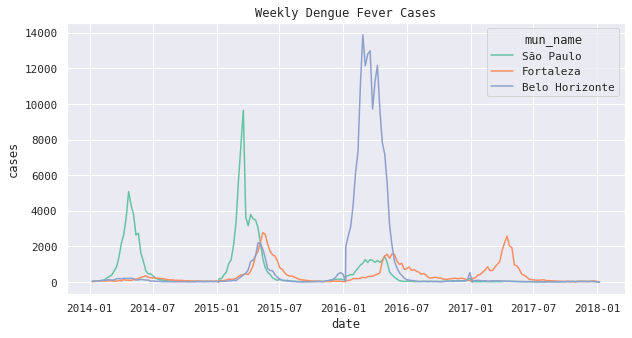

In [5]:
# plot the time series for some cities
plt.figure(figsize=(10,5))
sns.lineplot(data = data[data.mun_code.isin([355030, 310620, 230440])], 
             x='date', y='cases', 
             hue='mun_name',
            linewidth=1.5)
plt.title('Weekly Dengue Fever Cases')


### Data Preparation

We split the data into training and test sets. Since we are working with time series, we cannot randomize the split. Instead, we reserve the last five years of data for testing.

In [6]:
# split data into train and test sets
data_train = data[data.date<'2017-01-01']
data_test = data[data.date>='2017-01-01'] # reserve last year for hold-out set


In [7]:
    
def generate_ts(data, max_lags):
    '''
    
    '''
    # reformat data so that the features are historical Dengue cases
    data_ts = data.loc[:,['mun_code','mun_name', 'date', 'cases']].sort_values(by='date')
    data_ts.set_index(['mun_code', 'mun_name', 'date'], inplace=True)

    use_data = data_ts.copy()
    for l in np.arange(1, max_lags):
        df = use_data.copy()
        df_1 = df.groupby(level=0).shift(l)
        df_1.columns = df_1.columns+'_lag'+str(l)
        # combine
        data_ts = pd.concat([data_ts, df_1], axis=1)
    # reset index    
    data_ts = data_ts.reset_index()
    
    return data_ts


In [8]:
max_lags = 10
train_ts = generate_ts(data_train, max_lags)
test_ts = generate_ts(data_test, max_lags)


We now have a dataframe, with the 'current' case count as well as columns for historic values. Each of these rows will count as one observation for our time series forecasting model. 

As we can see below, first rows of data will contain missing values in the lag columns.

In [9]:
# inspect
train_ts[train_ts.mun_name=='São Paulo'][0:5]

,mun_code,mun_name,date,cases,cases_lag1,cases_lag2,cases_lag3,cases_lag4,cases_lag5,cases_lag6,cases_lag7,cases_lag8,cases_lag9
0,355030,São Paulo,2014-01-08,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,355030,São Paulo,2014-01-15,35.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,355030,São Paulo,2014-01-22,59.0,35.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,355030,São Paulo,2014-01-29,58.0,59.0,35.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
14,355030,São Paulo,2014-02-05,100.0,58.0,59.0,35.0,21.0,NaN,NaN,NaN,NaN,NaN


In [10]:
# drop the rows with missing values introduced during the shifting
train_ts.dropna(axis=0, inplace = True)
test_ts.dropna(axis=0, inplace = True)


In [11]:
# we can see that the corresponding rows are removed:
train_ts[train_ts.mun_name=='São Paulo'][0:5]

,mun_code,mun_name,date,cases,cases_lag1,cases_lag2,cases_lag3,cases_lag4,cases_lag5,cases_lag6,cases_lag7,cases_lag8,cases_lag9
29,355030,São Paulo,2014-03-12,615.0,379.0,301.0,227.0,101.0,100.0,58.0,59.0,35.0,21.0
30,355030,São Paulo,2014-03-19,846.0,615.0,379.0,301.0,227.0,101.0,100.0,58.0,59.0,35.0
35,355030,São Paulo,2014-03-26,1385.0,846.0,615.0,379.0,301.0,227.0,101.0,100.0,58.0,59.0
36,355030,São Paulo,2014-04-02,2178.0,1385.0,846.0,615.0,379.0,301.0,227.0,101.0,100.0,58.0
39,355030,São Paulo,2014-04-09,2671.0,2178.0,1385.0,846.0,615.0,379.0,301.0,227.0,101.0,100.0


In [12]:
# normalize data based on training set
mean = np.mean(train_ts.iloc[:,3:], axis=0)
std = np.std(train_ts.iloc[:,3:], axis=0)

train_ts_norm = train_ts.copy()
test_ts_norm = test_ts.copy()
train_ts_norm.iloc[:,3:] = (train_ts_norm.iloc[:,3:] - mean)/std
test_ts_norm.iloc[:,3:] = (test_ts_norm.iloc[:,3:] - mean) / std


In [13]:
# separate the targets and the features
train_y = train_ts_norm.loc[:,'cases']
train_x = train_ts_norm.iloc[:,4:]

test_y = test_ts_norm.loc[:,'cases']
test_x = test_ts_norm.iloc[:,4:]


### Hyperparameter tuning

We will implement a Multilayer Perceptron (MLP) model. There are several hyperparameters that may affect model performance, so we will perform a random search to select the best values for some of them:
- number of hidden layers and corresponding units
- activation function


In [14]:
# NN model

# hyperparameter tuning

# time series cross-validation
n_splits = 2
tscv = TimeSeriesSplit(n_splits=n_splits, max_train_size=None)
# set up the regressor
mlp_reg = MLPRegressor(max_iter=900, solver='adam', alpha = 0.4)
# set up the parameter space
parameter_grid = {'hidden_layer_sizes': [(64,64,64,), (64,64,), (64,),
                                        (32,32,32,), (32,32,), (32,),
                                        (16,32,64,), (16,64,),
                                        (64,32,16,), (64,32,),],
                  'activation': ['tanh', 'relu', 'logistic']
                  }
# grid search
clf = GridSearchCV(estimator = mlp_reg, cv=tscv, param_grid=parameter_grid)

'''
# alternatively, we can run a randomized search:
parameter_space = {'hidden_layer_sizes': [(randint.rvs(5,100,),randint.rvs(5,100,), randint.rvs(5,100,)), 
                                          (randint.rvs(5,100,),randint.rvs(5,100,),), 
                                          (randint.rvs(5,100,),)],
                  'activation': ['tanh', 'relu', 'logistic']
                  }
#clf = RandomizedSearchCV(estimator = mlp_reg, cv=tscv, param_distributions=parameter_space, n_iter=200)
'''

search_result = clf.fit(train_x, train_y)


In [15]:
# the best parameters:
search_result.best_params_

{'activation': 'relu', 'hidden_layer_sizes': (32, 32)}

In [16]:
# R-squared of the best model:
search_result.best_score_

0.7805328196980996

### Train the model using time series CV


In [17]:
y_pred_train = clf.predict(train_x)

In [18]:
y_pred_train.shape
train_y.shape
data_train.loc[:,'mun_name'].shape
data_train.loc[:,'date'].shape

(474,)

In [19]:
predictions_train = pd.DataFrame({'predictions_train':y_pred_train,
                                 'actual_train': train_y,
                                 'city': train_ts.loc[:,'mun_name'],
                                 'date': train_ts.loc[:,'date']
                                 })

### Test set predictions

In [20]:
# prediction on test set
y_pred = clf.predict(test_x)


In [21]:
# reverse normalization to return to true values
y_pred_real = (y_pred * std['cases']) + mean['cases']

In [22]:
# mae
mae =  mean_absolute_error(test_y, y_pred)
# rmse
rmse = mean_squared_error(y_true=test_y, y_pred=y_pred, squared=False)

# mae real
mae_real =  mean_absolute_error(test_ts.loc[:,'cases'], y_pred_real)
# rmse
rmse_real = mean_squared_error(y_true=test_ts.loc[:,'cases'], y_pred=y_pred_real, squared=False)


In [23]:
error_metrics = pd.DataFrame({'mae': mae, 
                             'rmse': rmse,
                             'mae_real': mae_real,
                             'rmse_real':rmse_real}, index=['errors'])

In [24]:
round(error_metrics, 3)

,mae,rmse,mae_real,rmse_real
errors,0.029,0.057,58.178,113.498


In [25]:
# plots for countries

pred_df = pd.DataFrame({'predictions': y_pred,
                         'predictions_real': y_pred_real,
                         'actual': test_y,
                         'actual_real': test_ts.loc[:,'cases'],
                         'city': test_ts.loc[:,'mun_name'],
                         'date': test_ts.loc[:,'date']
                       })

### Sample Plots

In [26]:
# we'll plot the real and predicted values for a single city
city = 'Fortaleza'
pred_city = pred_df[pred_df.city == city]
pred_train_city = predictions_train[predictions_train.city== city]



Text(0.5, 1.0, 'Fortaleza')

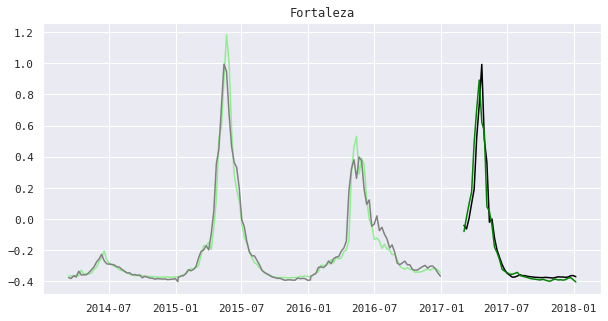

In [27]:
plt.figure(figsize=(10,5))
plt.plot(pred_city.date, pred_city.predictions, color='black')
plt.plot(pred_city.date, pred_city.actual, color = 'green')
plt.plot(pred_train_city.date, pred_train_city.predictions_train, color='lightgreen')
plt.plot(pred_train_city.date, pred_train_city.actual_train, color = 'gray')
plt.title(city)